In [91]:
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterSampler
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import seaborn as sns
import re
from datetime import datetime
import random
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from src.models.utils import milling_add_y_label_anomaly, under_over_sampler, calculate_scores, get_classifier_and_params, get_model_metrics_df
from src.models.train import train_single_model
from src.models.random_search_setup import general_params
from src.models.classifiers import (
    rf_classifier,
    xgb_classifier,
    knn_classifier,
    lr_classifier,
    sgd_classifier,
    ridge_classifier,
    svm_classifier,
    nb_classifier,
)

from sklearn.metrics import (
    roc_auc_score,
    auc,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
)

from src.models.random_search_setup import (
    rf_params,
    xgb_params,
    knn_params,
    lr_params,
    sgd_params,
    ridge_params,
    svm_params,
    nb_params,
)

from src.visualization.visualize import plot_pr_roc_curves_kfolds

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
path_data_folder = Path().cwd().parent.parent / 'data'
print(path_data_folder)

folder_raw_data_milling = path_data_folder / "raw/milling"
folder_interim_data_milling = path_data_folder / "interim/milling"
folder_processed_data_milling = path_data_folder / "processed/milling"

/home/tim/Documents/feat-store/data


In [5]:
Y_LABEL_COL = 'y'

# identify if there is another column you want to 
# stratify on, besides the y label
STRATIFICATION_GROUPING_COL = 'cut_no'

# list of the columns that are not features columns
# (not including the y-label column)
META_LABEL_COLS = ['cut_id', 'cut_no', 'case', 'tool_class']

RAND_SEARCH_ITER = 10

# set a seed for the parameter sampler
# SAMPLER_SEED = random.randint(0, 2 ** 16)

# load feature dataframe
df = pd.read_csv(
    folder_processed_data_milling / "milling.csv",
    )

# add y label
df = milling_add_y_label_anomaly(df)

Y_LABEL_COL = 'y'

# identify if there is another column you want to 
# stratify on, besides the y label
STRATIFICATION_GROUPING_COL = 'cut_no'

# list of the columns that are not features columns
# (not including the y-label column)
META_LABEL_COLS = ['cut_id', 'cut_no', 'case', 'tool_class']

In [92]:
date_time = datetime.now().strftime("%Y.%m.%d-%H.%M.%S")
date_time


'2022.02.02-15.48.53'

In [90]:
sample_seed = random.randint(0, 10 ** 10)
sample_seed

8001797165

In [97]:
def random_search_runner(df, rand_search_iter, meta_label_cols, stratification_grouping_col, path_save_dir=None, y_label_col='y', save_freq=1):
    
    for i in range(rand_search_iter):

        # set random sample seed
        sample_seed = random.randint(0, 2 ** 25)

        model_metrics_dict, params_dict_clf_named, params_dict_train_setup = train_single_model(df, sample_seed, 
        meta_label_cols, stratification_grouping_col, y_label_col)

        df_t = pd.DataFrame.from_dict(params_dict_train_setup, orient="index").T # train setup params
        df_c = pd.DataFrame.from_dict(params_dict_clf_named, orient="index").T # classifier params
        df_m = get_model_metrics_df(model_metrics_dict)

        if i == 0:
            df_results = pd.concat([df_t, df_m, df_c], axis=1)

            file_name = f'results_{sample_seed}.csv'
        else:
            df_results = df_results.append(pd.concat([df_t, df_m, df_c], axis=1))

        if i % save_freq == 0:
            if path_save_dir is not None:
                df_results.to_csv(path_save_dir / file_name, index=False)
            else:
                df_results.to_csv(file_name, index=False)
        



In [98]:
random_search_runner(df, rand_search_iter=3, meta_label_cols=META_LABEL_COLS, stratification_grouping_col=STRATIFICATION_GROUPING_COL, path_save_dir=None, y_label_col='y')

classifier: rf, uo_method: random_over, imbalance_ratio: 0.5

 {'RandomForestClassifier_bootstrap': False, 'RandomForestClassifier_class_weight': None, 'RandomForestClassifier_criterion': 'gini', 'RandomForestClassifier_max_depth': 158, 'RandomForestClassifier_min_samples_leaf': 8, 'RandomForestClassifier_min_samples_split': 4, 'RandomForestClassifier_n_estimators': 311}
classifier: knn, uo_method: adasyn, imbalance_ratio: 0.5

 {'KNeighborsClassifier_metric': 'chebyshev', 'KNeighborsClassifier_n_neighbors': 3, 'KNeighborsClassifier_weights': 'distance'}
classifier: nb, uo_method: random_under_bootstrap, imbalance_ratio: 0.1

 {}


In [5]:
sample_seed_list = [9, 13]

for i, sample_seed in enumerate(sample_seed_list):
    model_metrics_dict, params_dict_clf_named, params_dict_train_setup = train_single_model(df, sampler_seed=sample_seed, 
    meta_label_cols=META_LABEL_COLS, stratification_grouping_col=STRATIFICATION_GROUPING_COL, y_label_col='y')

    df_t = pd.DataFrame.from_dict(params_dict_train_setup, orient="index").T # train setup params
    df_c = pd.DataFrame.from_dict(params_dict_clf_named, orient="index").T # classifier params
    df_m = get_model_metrics_df(model_metrics_dict)

    if i == 0:
        df_results = pd.concat([df_t, df_m, df_c], axis=1)
    else:
        df_results = df_results.append(pd.concat([df_t, df_m, df_c], axis=1))


classifier: ridge, uo_method: adasyn, imbalance_ratio: 0.3

 {'RidgeClassifier_alpha': 0.051870769428499774}
classifier: sgd, uo_method: random_under_bootstrap, imbalance_ratio: 0.8

 {'SGDClassifier_eta0': 1.5554048211476403, 'SGDClassifier_fit_intercept': True, 'SGDClassifier_l1_ratio': 0.8594340147396812, 'SGDClassifier_learning_rate': 'invscaling', 'SGDClassifier_loss': 'perceptron', 'SGDClassifier_penalty': 'l2'}


In [6]:
df_results

,uo_method,scaler_method,imbalance_ratio,classifier,sampler_seed,precision_score_min,precision_score_max,precision_score_avg,precision_score_std,recall_score_min,...,accuracy_std,n_thresholds_min,n_thresholds_max,RidgeClassifier_alpha,SGDClassifier_eta0,SGDClassifier_fit_intercept,SGDClassifier_l1_ratio,SGDClassifier_learning_rate,SGDClassifier_loss,SGDClassifier_penalty
0,adasyn,minmax,0.3,ridge,9,0.00000,0.176471,0.108654,0.059535,0.000000,...,0.003672,9198.0,9301.0,0.051871,NaN,NaN,NaN,NaN,NaN,NaN
0,random_under_bootstrap,standard,0.8,sgd,13,0.08453,0.152528,0.116384,0.023915,0.204724,...,0.047527,9198.0,9301.0,NaN,1.555405,True,0.859434,invscaling,perceptron,l2


classifier: ridge, uo_method: adasyn, imbalance_ratio: 0.3

 {'RidgeClassifier_alpha': 0.051870769428499774}


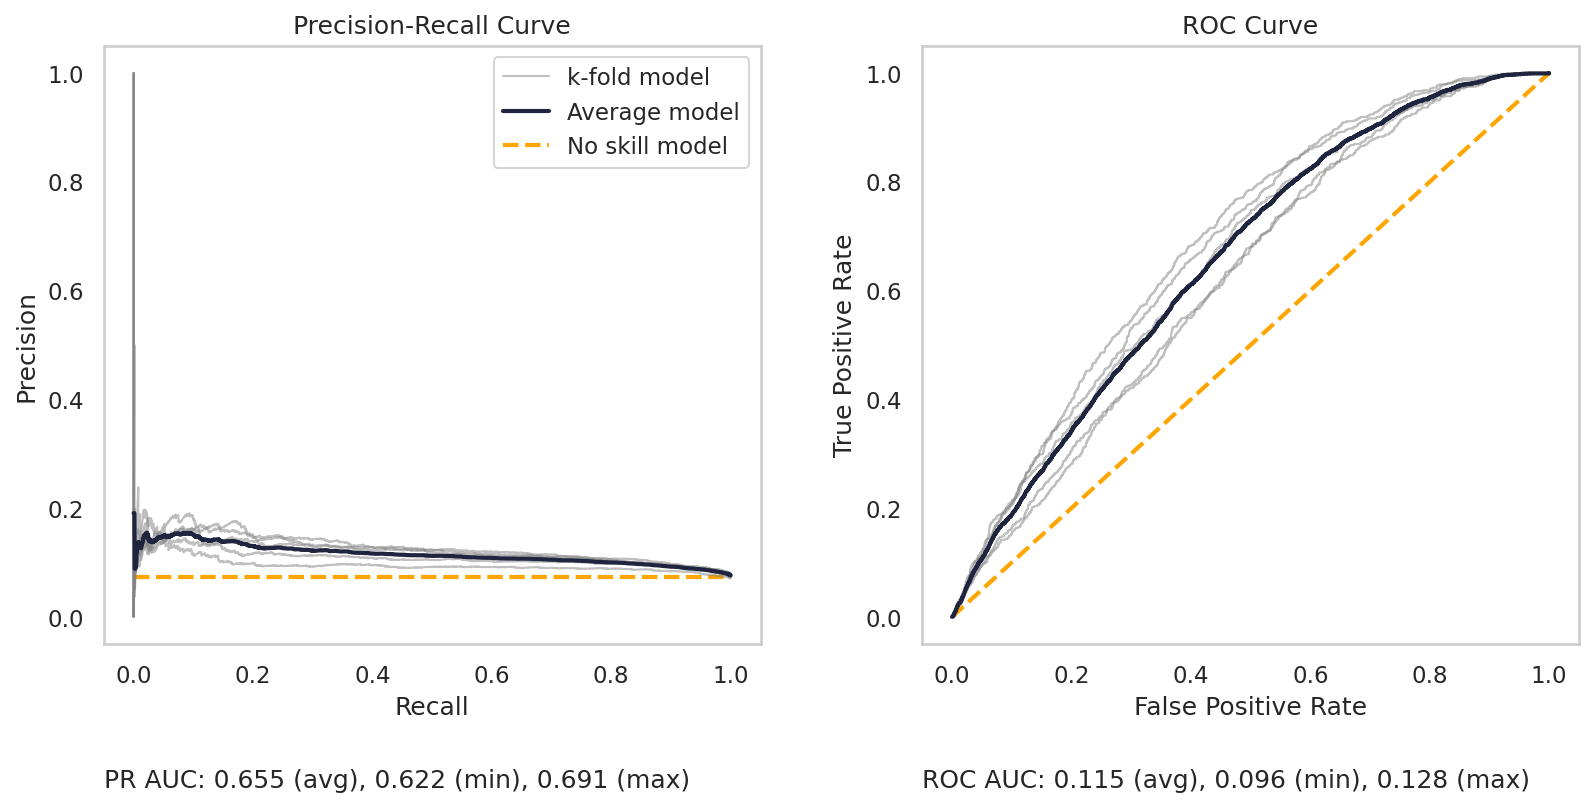

In [7]:
SAMPLER_SEED = 9

trained_result_dict, params_dict_clf_named, params_dict_train_setup = train_single_model(df, sampler_seed=SAMPLER_SEED, meta_label_cols=META_LABEL_COLS, stratification_grouping_col=STRATIFICATION_GROUPING_COL, y_label_col='y')

precision_array, recall_array, fpr_array, tpr_array, prauc_array, rocauc_array = trained_result_dict['precisions_array'], trained_result_dict['recalls_array'], trained_result_dict['fpr_array'], trained_result_dict['tpr_array'], trained_result_dict['prauc_array'], trained_result_dict['rocauc_array']

plot_pr_roc_curves_kfolds(precision_array, recall_array, fpr_array, tpr_array, prauc_array, rocauc_array)

In [19]:
df_t = pd.DataFrame.from_dict(params_dict_train_setup, orient="index").T # train setup params
df_c = pd.DataFrame.from_dict(params_dict_clf_named, orient="index").T # classifier params
df_c.head()


,LogisticRegression_class_weight,LogisticRegression_l1_ratio,LogisticRegression_max_iter,LogisticRegression_penalty,LogisticRegression_solver
0,balanced,None,20000,none,saga


In [22]:
df_results = df_results.append(
    pd.concat([df_t, df_c], axis=1)
)

In [23]:
df_results.head()

,uo_method,scaler_method,imbalance_ratio,classifier,RidgeClassifier_alpha,LogisticRegression_class_weight,LogisticRegression_l1_ratio,LogisticRegression_max_iter,LogisticRegression_penalty,LogisticRegression_solver
0,adasyn,minmax,0.3,ridge,0.051871,NaN,NaN,NaN,NaN,NaN
0,random_under,standard,0.8,lr,NaN,balanced,None,20000,none,saga


In [17]:
df_results = pd.concat([df_t, df_c], axis=1)
df_results.head()

,uo_method,scaler_method,imbalance_ratio,classifier,RidgeClassifier_alpha
0,adasyn,minmax,0.3,ridge,0.051871


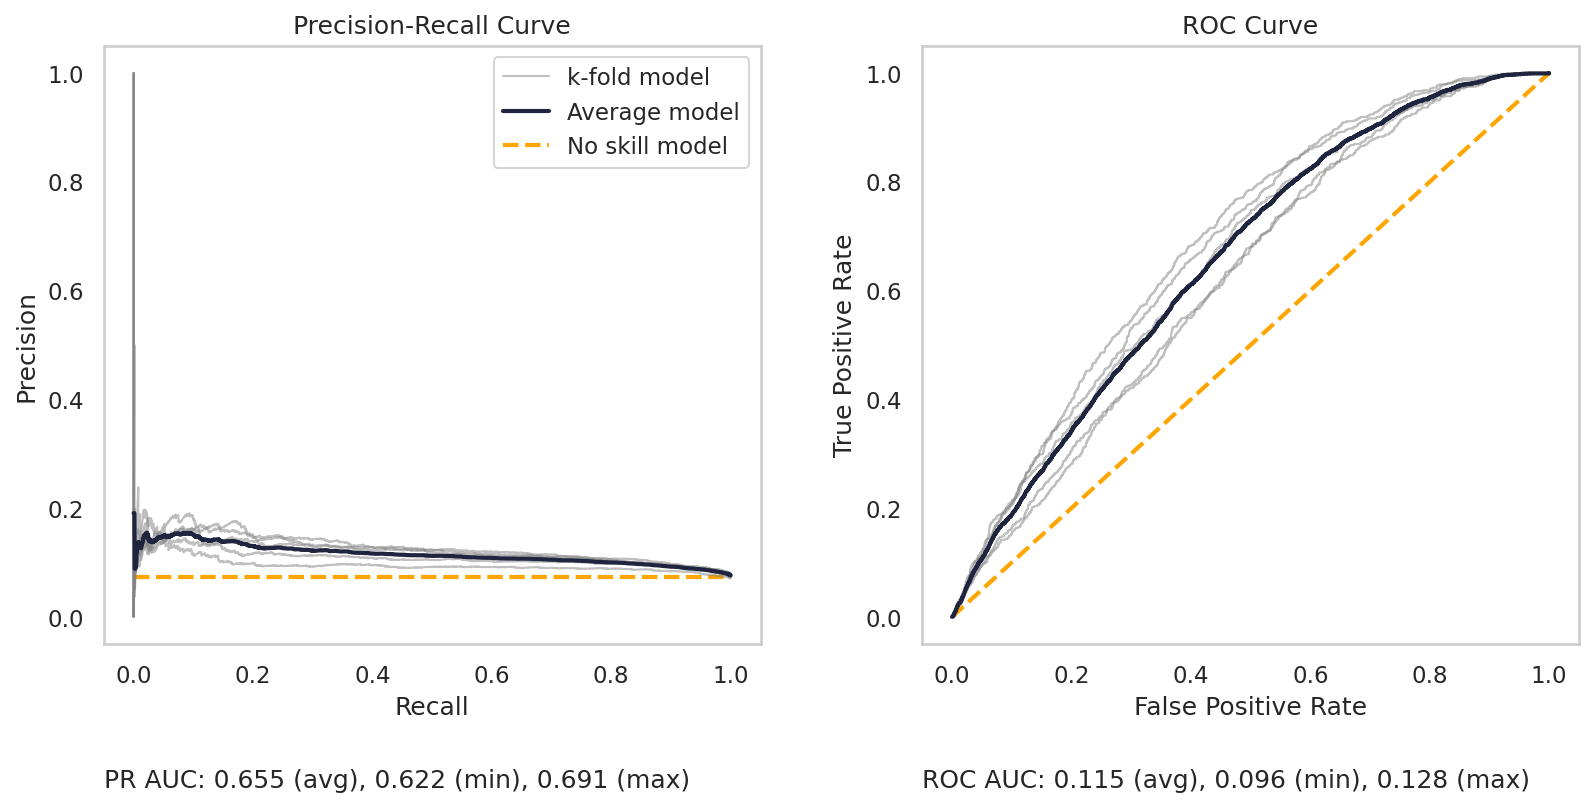

In [8]:
precision_array, recall_array, fpr_array, tpr_array, prauc_array, rocauc_array = results_dict['precisions'], results_dict['recalls'], results_dict['fpr'], results_dict['tpr'], results_dict['prauc'], results_dict['rocauc']

plot_pr_roc_curves_kfolds(precision_array, recall_array, fpr_array, tpr_array, prauc_array, rocauc_array)